# **GRU for News Classification**

In [1]:
!pip -q install portalocker
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q torchtext==0.15.2
!pip install -q torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.7/848.7 MB 794.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [2]:
#Dependencies
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

import torch
import random
import torchtext
import string
from torchtext.vocab import build_vocab_from_iterator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchinfo import summary
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

import itertools
from torchtext.datasets import AG_NEWS
from collections import Counter
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [4]:
train_data, test_data = AG_NEWS(split=('train', 'test'))

train_length = sum(1 for _ in train_data)
test_length = sum(1 for _ in test_data)

print("Train data length:", train_length)
print("Test data length:", test_length)

#Printing first 3 news samples
for i, sample in enumerate(train_data):
    if i == 3:
        break
    print(sample)

#To see class distribution
class_counts = Counter(label for label, _ in train_data)
print(class_counts)

Train data length: 120000
Test data length: 7600
(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
(3, 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')
(3, "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Counter({3: 30000, 4: 30000, 2: 30000, 1: 30000})


In [5]:
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)


def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations]
    return tokens

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield preprocess_text(text)

def numericalize(text):
    return vocab(preprocess_text(text))

#Building the vocabulary from train dataset
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

processed_train = [(label, numericalize(text)) for label, text in train_data]
processed_test = [(label, numericalize(text)) for label, text in test_data]


In [6]:
#Check if preprocessing steps worked
for i, sample in enumerate(processed_train):
    if i == 3:
        break
    print(sample)

(3, [335, 459, 1469, 14768, 59, 737, 5, 5, 51776, 335, 284, 2, 71033, 53355, 3864, 670])
(3, [15836, 954, 740, 1170, 4096, 5, 5, 808, 681, 232, 15836, 46, 27831, 4301, 461, 53874, 84504, 1990, 421, 167, 3739, 86755, 6424, 133, 269, 68])
(3, [21, 260, 4439, 89, 623, 5, 5, 2249, 353, 39, 1925, 27506, 260, 623, 188, 165, 53019, 209, 68, 58, 36, 7722, 40576, 15319])


In [7]:
MAX_LEN = 256 # Given. Maybe too big. Most of the tokens are pad tokens
PAD_TOKEN = 0

train_data = list(processed_train)  # Convert to python list to split
test_data = list(processed_test)

train_size=int(0.8*len(train_data))
val_size=len(train_data)-train_size

print('Train set size: '+str(train_size))
print('Validation set size: '+str(val_size))

random.shuffle(train_data)

#Creating the validation set
training_data=list(train_data)[:train_size]
validation_data=list(train_data)[train_size:train_size+val_size]


def pad_sequence(seq, max_len=MAX_LEN):
    seq = torch.tensor(seq)
    if len(seq) < max_len:
        seq = torch.cat([seq, torch.full((max_len - len(seq),), PAD_TOKEN, dtype=torch.long)])
    else:
        seq = seq[:max_len]
    return seq

#Padding sequences to length 256
padded_train = [(label, pad_sequence(text)) for label, text in training_data]
padded_val = [(label, pad_sequence(text)) for label, text in validation_data]
padded_test = [(label, pad_sequence(text)) for label, text in test_data]

Train set size: 96000
Validation set size: 24000


In [8]:
#Padded sequences
for i, sample in enumerate(padded_train):
    if i == 3:
        break
    print(sample)

(4, tensor([  563,  1296,   710,   111,   563,  1221,   219,   111,   616,   844,
         1057, 13591,   111,  6295,  1284,    20,   909, 15058,  1051, 25996,
          111,   417,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

In [9]:
#Label encoding to 0, 1, 2, 3
final_train = [(label-1, text) for label, text in padded_train]
final_val = [(label-1, text) for label, text in padded_val]
final_test = [(label-1, text) for label, text in padded_test]

all_labels = {label for label, _ in final_train} | \
             {label for label, _ in final_val} | \
             {label for label, _ in final_test}

print("Unique labels:", all_labels)

Unique labels: {0, 1, 2, 3}


In [11]:
#One hot encoding of the labels
def one_hot_encode(label, num_classes=4):
    return torch.eye(num_classes)[label]

one_hot_labels = [one_hot_encode(label) for label, _ in final_train] #Not using this for the model because cross entropy loss requires logits

unique_one_hot_labels = {tuple(label.tolist()) for label in one_hot_labels}

print("One Hot Encoding of the Labels")
for encoding in unique_one_hot_labels:
    print(torch.tensor(encoding))

One Hot Encoding of the Labels
tensor([0., 0., 0., 1.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([1., 0., 0., 0.])


In [12]:
#Hyperparameters
BATCH_SIZE=64
MAX_LEN = 256
PAD_IDX = vocab["<pad>"]
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 4
NUM_EPOCHS = 10
LEARNING_RATE = 0.001 # Initially it is slow. Tried 0.01 but loss diverges.
DROPOUT_PROB = 0.1

In [13]:
def create_dataloader(processed_data, batch_size):
    labels = torch.tensor([label for label, _ in processed_data], dtype=torch.long)
    sequences = torch.stack([text for _, text in processed_data])
    dataset = TensorDataset(sequences, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

#Creating dataloader
train_loader = create_dataloader(final_train, BATCH_SIZE)
val_loader = create_dataloader(final_val, BATCH_SIZE)
test_loader = create_dataloader(final_test, BATCH_SIZE)

In [15]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, dropout_prob):
        super(GRUClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=2, dropout=dropout_prob, batch_first=True) # 2 layers separated by dropout
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])  # FC layer applied on the output of last time step
        return out

In [16]:
#Training loop
def train_model(model, train_loader, val_loader, scheduler, epochs):
    train_losses, val_losses = [], [] #for plot
    train_accuracies, val_accuracies = [], [] #for printing after each epoch

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        correct_train, total_train = 0, 0

        for texts, labels in tqdm(train_loader):
          texts, labels = texts.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(texts)

          loss = criterion(outputs, labels)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
          optimizer.step()
          total_loss += loss.item()

          predictions = torch.argmax(outputs, dim=1)
          correct_train += (predictions == labels).sum().item()
          total_train += labels.size(0)

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

    # Validation loop
        model.eval()
        total_val_loss = 0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)

            # Compute accuracy
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                correct_val += (predictions == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)  #LR scheduling to prevent stagnation

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss Over Epochs")
    plt.show()

In [17]:
def test_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
      for texts, labels in tqdm(test_loader):
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

    #Evaluation metrics from sklearn
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

100%|██████████| 1500/1500 [01:03<00:00, 23.77it/s]


Epoch [1/10], Train Accuracy: 0.2499, Val Accuracy: 0.2490


100%|██████████| 1500/1500 [01:03<00:00, 23.60it/s]


Epoch [2/10], Train Accuracy: 0.2487, Val Accuracy: 0.2483


100%|██████████| 1500/1500 [01:03<00:00, 23.62it/s]


Epoch [3/10], Train Accuracy: 0.2528, Val Accuracy: 0.2547


100%|██████████| 1500/1500 [01:02<00:00, 23.93it/s]


Epoch [4/10], Train Accuracy: 0.2469, Val Accuracy: 0.2480


100%|██████████| 1500/1500 [01:02<00:00, 24.11it/s]


Epoch [5/10], Train Accuracy: 0.2519, Val Accuracy: 0.2464


100%|██████████| 1500/1500 [01:03<00:00, 23.70it/s]


Epoch [6/10], Train Accuracy: 0.5208, Val Accuracy: 0.7140


100%|██████████| 1500/1500 [01:03<00:00, 23.71it/s]


Epoch [7/10], Train Accuracy: 0.7537, Val Accuracy: 0.7851


100%|██████████| 1500/1500 [01:02<00:00, 23.95it/s]


Epoch [8/10], Train Accuracy: 0.8113, Val Accuracy: 0.7961


100%|██████████| 1500/1500 [01:03<00:00, 23.67it/s]


Epoch [9/10], Train Accuracy: 0.8434, Val Accuracy: 0.8118


100%|██████████| 1500/1500 [01:02<00:00, 23.94it/s]


Epoch [10/10], Train Accuracy: 0.8698, Val Accuracy: 0.8108


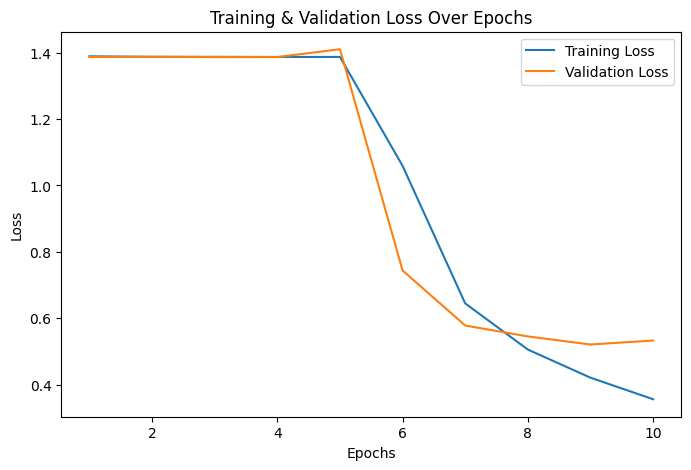

100%|██████████| 118/118 [00:01<00:00, 86.67it/s]


Accuracy: 0.8020
Precision: 0.8062
Recall: 0.8020
Confusion Matrix:
[[1435  113  209  128]
 [  74 1630   96   84]
 [  65   80 1535  213]
 [  80   74  279 1457]]


In [ ]:
gru_model = GRUClassifier(len(vocab), EMBED_DIM, HIDDEN_DIM, NUM_CLASSES, DROPOUT_PROB).to(device)
criterion = nn.CrossEntropyLoss() # For 4 class classification
optimizer = optim.Adam(gru_model.parameters(), lr=LEARNING_RATE) # Adam optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

#Training
train_model(gru_model, train_loader, val_loader, scheduler, NUM_EPOCHS)
# Evaluation
test_model(gru_model, test_loader)

In [ ]:
actual_input, _ = next(iter(train_loader))
actual_input = actual_input.to(dtype=torch.long, device=device)
summary(gru_model, input_data=actual_input, col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
GRUClassifier                            [64, 256]                 [64, 4]                   --                        True
├─Embedding: 1-1                         [64, 256]                 [64, 256, 128]            12,797,568                True
├─GRU: 1-2                               [64, 256, 128]            [64, 256, 256]            691,200                   True
├─Linear: 1-3                            [64, 256]                 [64, 4]                   1,028                     True
Total params: 13,489,796
Trainable params: 13,489,796
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 12.14
Input size (MB): 0.13
Forward/backward pass size (MB): 50.33
Params size (MB): 53.96
Estimated Total Size (MB): 104.42